<a href="https://colab.research.google.com/github/nirvika3395/ArtificialIntelligence--Project-/blob/main/Fake_News_Detection_PyTorch_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset

In [ ]:
import pandas as pd

In [ ]:
ds = load_dataset(
    "koliskos/fake_news",
    data_files={"fake": "Fake.csv", "true": "True.csv"}
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Fake.csv:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

True.csv:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Generating fake split: 0 examples [00:00, ? examples/s]

Generating true split: 0 examples [00:00, ? examples/s]

In [ ]:
print(ds)
print(ds.keys())

DatasetDict({
    fake: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 23481
    })
    true: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 21417
    })
})
dict_keys(['fake', 'true'])


In [ ]:
df_fake = ds["fake"].to_pandas()
df_true = ds["true"].to_pandas()

df_fake["label"] = 0   # Fake news
df_true["label"] = 1   # True news

print("Fake labels:\n", df_fake["label"].value_counts())
print("True labels:\n", df_true["label"].value_counts())

Fake labels:
 label
0    23481
Name: count, dtype: int64
True labels:
 label
1    21417
Name: count, dtype: int64


In [ ]:

df = pd.concat([df_fake, df_true], ignore_index=True)

print("Final dataset shape:", df.shape)
print(df["label"].value_counts())

Final dataset shape: (44898, 5)
label
0    23481
1    21417
Name: count, dtype: int64


In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
import re

In [ ]:
def clean_text(text):
    text = "" if text is None else str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")

df["content"] = df["title"] + " " + df["text"]
df["content_clean"] = df["content"].apply(clean_text)

df[["content_clean", "label"]].head()

,content_clean,label
0,ben stein calls out th circuit court committed...,0
1,trump drops steve bannon from national securit...,1
2,puerto rico expects u s to lift jones act ship...,1
3,oops trump just accidentally confirmed he leak...,0
4,donald trump heads for scotland to reopen a go...,1


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# labels
y = df["label"].astype(int).values

# TF-IDF (high dimensional, sparse)
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2,
    max_df=0.95
)

X = tfidf.fit_transform(df["content_clean"])

print("TF-IDF shape:", X.shape)
print("Label distribution:", np.bincount(y))


TF-IDF shape: (44898, 50000)
Label distribution: [23481 21417]


In [ ]:
from sklearn.model_selection import train_test_split

X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp,
    y_train_temp,
    test_size=0.20,
    random_state=42,
    stratify=y_train_temp
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Train: (28734, 50000)
Val  : (7184, 50000)
Test : (8980, 50000)


In [ ]:
import tensorflow as tf

def csr_to_tf_sparse(csr):
    coo = csr.tocoo()
    indices = np.vstack((coo.row, coo.col)).T
    return tf.sparse.reorder(
        tf.sparse.SparseTensor(
            indices=indices,
            values=coo.data.astype(np.float32),
            dense_shape=coo.shape
        )
    )

Xtr = csr_to_tf_sparse(X_train)
Xva = csr_to_tf_sparse(X_val)
Xte = csr_to_tf_sparse(X_test)

ytr = y_train.astype(np.float32)
yva = y_val.astype(np.float32)
yte = y_test.astype(np.float32)

input_dim = X_train.shape[1]
print("Input dim:", input_dim)


Input dim: 50000


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(input_dim,), sparse=True),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc")
    ]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │    12,800,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,833,281 (48.96 MB)

 Trainable params: 12,833,281 (48.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=3,
        restore_best_weights=True
    )
]

history = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=20,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 489ms/step - accuracy: 0.9259 - auc: 0.9650 - loss: 0.3325 - val_accuracy: 0.9921 - val_auc: 0.9990 - val_loss: 0.0263
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 328ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0066 - val_accuracy: 0.9933 - val_auc: 0.9990 - val_loss: 0.0227
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0011 - val_accuracy: 0.9939 - val_auc: 0.9990 - val_loss: 0.0225
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 4.6773e-04 - val_accuracy: 0.9942 - val_auc: 0.9989 - val_loss: 0.0230


In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# Predictions
probs = model.predict(Xte, batch_size=512).ravel()
preds = (probs >= 0.5).astype(int)

print("\nKeras Neural Network Results")
print("Accuracy:", round(accuracy_score(yte, preds), 4))
print("F1      :", round(f1_score(yte, preds), 4))
print("ROC-AUC :", round(roc_auc_score(yte, probs), 4))
print("PR-AUC  :", round(average_precision_score(yte, probs), 4))
print("\nClassification Report:\n", classification_report(yte, preds, digits=4))


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step

Keras Neural Network Results
Accuracy: 0.9921
F1      : 0.9917
ROC-AUC : 0.9994
PR-AUC  : 0.9995

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9949    0.9900    0.9924      4696
         1.0     0.9891    0.9944    0.9917      4284

    accuracy                         0.9921      8980
   macro avg     0.9920    0.9922    0.9921      8980
weighted avg     0.9921    0.9921    0.9921      8980



In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [19]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: False
CUDA device count: 0
CUDA device name: No GPU


In [20]:
class CSRBagDataset(Dataset):
    """
    Turns a CSR sparse matrix row into:
      - idx: feature indices (int64)
      - val: feature values (float32)
      - offsets: start index for this single 'bag' (always [0] for one sample)
    """
    def __init__(self, X_csr, y):
        self.X = X_csr.tocsr()
        self.y = y.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        row = self.X.getrow(i)
        idx = row.indices.astype(np.int64)
        val = row.data.astype(np.float32)
        offsets = np.array([0], dtype=np.int64)
        label = self.y[i]
        return idx, val, offsets, label


In [21]:
def collate_bag(batch):
    idx_list, val_list, offsets_list, y_list = zip(*batch)

    # concatenate all indices/values
    idx = np.concatenate(idx_list)
    val = np.concatenate(val_list)

    # offsets: start positions for each sample within the concatenated idx/val
    lengths = [len(x) for x in idx_list]
    offsets = np.zeros(len(lengths), dtype=np.int64)
    if len(lengths) > 1:
        offsets[1:] = np.cumsum(lengths)[:-1]

    return (
        torch.from_numpy(idx),
        torch.from_numpy(val),
        torch.from_numpy(offsets),
        torch.tensor(y_list, dtype=torch.float32)
    )


In [22]:
train_ds = CSRBagDataset(X_train, y_train)
val_ds   = CSRBagDataset(X_val, y_val)
test_ds  = CSRBagDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True,  collate_fn=collate_bag)
val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False, collate_fn=collate_bag)
test_loader  = DataLoader(test_ds,  batch_size=1024, shuffle=False, collate_fn=collate_bag)


In [23]:
class EmbeddingBagMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.emb = nn.EmbeddingBag(vocab_size, embed_dim, mode="sum", sparse=False)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)  # logits
        )

    def forward(self, idx, val, offsets):
        # per-sample embedding: (batch, embed_dim)
        x = self.emb(idx, offsets, per_sample_weights=val)
        logits = self.mlp(x).squeeze(1)
        return logits

vocab_size = X_train.shape[1]  # number of TF-IDF features
model = EmbeddingBagMLP(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, dropout=0.3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


EmbeddingBagMLP(
  (emb): EmbeddingBag(50000, 128, mode='sum')
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [24]:
from sklearn.metrics import roc_auc_score, average_precision_score

@torch.no_grad()
def eval_scores(model, loader):
    model.eval()
    probs_all, y_all = [], []

    for idx, val, offsets, yb in loader:
        idx = idx.to(device)
        val = val.to(device)
        offsets = offsets.to(device)
        yb = yb.cpu().numpy()

        logits = model(idx, val, offsets)
        probs = torch.sigmoid(logits).detach().cpu().numpy()

        probs_all.append(probs)
        y_all.append(yb)

    probs_all = np.concatenate(probs_all)
    y_all = np.concatenate(y_all)

    return roc_auc_score(y_all, probs_all), average_precision_score(y_all, probs_all)


In [25]:
best_auc = -1
patience = 3
pat = 0
best_state = None

for epoch in range(1, 21):
    model.train()
    total_loss = 0.0

    for idx, val, offsets, yb in train_loader:
        idx = idx.to(device)
        val = val.to(device)
        offsets = offsets.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(idx, val, offsets)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_auc, val_ap = eval_scores(model, val_loader)
    print(f"Epoch {epoch:02d} | loss={total_loss/len(train_loader):.4f} | val_auc={val_auc:.4f} | val_ap={val_ap:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_state)
model.to(device)
print("Best val AUC:", best_auc)


Epoch 01 | loss=0.4716 | val_auc=0.9678 | val_ap=0.9646
Epoch 02 | loss=0.1516 | val_auc=0.9906 | val_ap=0.9895
Epoch 03 | loss=0.0683 | val_auc=0.9949 | val_ap=0.9942
Epoch 04 | loss=0.0340 | val_auc=0.9964 | val_ap=0.9959
Epoch 05 | loss=0.0159 | val_auc=0.9970 | val_ap=0.9966
Epoch 06 | loss=0.0073 | val_auc=0.9973 | val_ap=0.9969
Epoch 07 | loss=0.0034 | val_auc=0.9974 | val_ap=0.9971
Epoch 08 | loss=0.0018 | val_auc=0.9975 | val_ap=0.9971
Epoch 09 | loss=0.0012 | val_auc=0.9976 | val_ap=0.9972
Epoch 10 | loss=0.0008 | val_auc=0.9976 | val_ap=0.9970
Epoch 11 | loss=0.0006 | val_auc=0.9976 | val_ap=0.9971
Epoch 12 | loss=0.0005 | val_auc=0.9977 | val_ap=0.9972
Epoch 13 | loss=0.0004 | val_auc=0.9977 | val_ap=0.9972
Epoch 14 | loss=0.0003 | val_auc=0.9977 | val_ap=0.9972
Epoch 15 | loss=0.0003 | val_auc=0.9977 | val_ap=0.9973
Epoch 16 | loss=0.0003 | val_auc=0.9978 | val_ap=0.9973
Epoch 17 | loss=0.0002 | val_auc=0.9978 | val_ap=0.9973
Epoch 18 | loss=0.0002 | val_auc=0.9978 | val_ap

In [26]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    probs_all, y_all = [], []
    for idx, val, offsets, yb in loader:
        idx = idx.to(device)
        val = val.to(device)
        offsets = offsets.to(device)

        logits = model(idx, val, offsets)
        probs = torch.sigmoid(logits).cpu().numpy()

        probs_all.append(probs)
        y_all.append(yb.numpy())
    return np.concatenate(probs_all), np.concatenate(y_all)

probs, ytrue = predict_probs(model, test_loader)
preds = (probs >= 0.5).astype(int)

print("\nPyTorch EmbeddingBag NN — Test Results")
print("Accuracy:", round(accuracy_score(ytrue, preds), 4))
print("F1      :", round(f1_score(ytrue, preds), 4))
print("ROC-AUC :", round(roc_auc_score(ytrue, probs), 4))
print("PR-AUC  :", round(average_precision_score(ytrue, probs), 4))
print("\nReport:\n", classification_report(ytrue, preds, digits=4))




PyTorch EmbeddingBag NN — Test Results
Accuracy: 0.9812
F1      : 0.9803
ROC-AUC : 0.9976
PR-AUC  : 0.997

Report:
               precision    recall  f1-score   support

         0.0     0.9809    0.9832    0.9820      4696
         1.0     0.9815    0.9790    0.9803      4284

    accuracy                         0.9812      8980
   macro avg     0.9812    0.9811    0.9811      8980
weighted avg     0.9812    0.9812    0.9812      8980



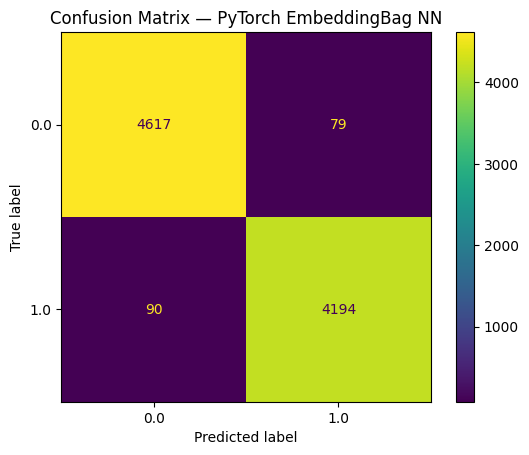

In [27]:
# Confusion Matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytrue, preds, ax=ax, values_format="d")
ax.set_title("Confusion Matrix — PyTorch EmbeddingBag NN")
plt.show()




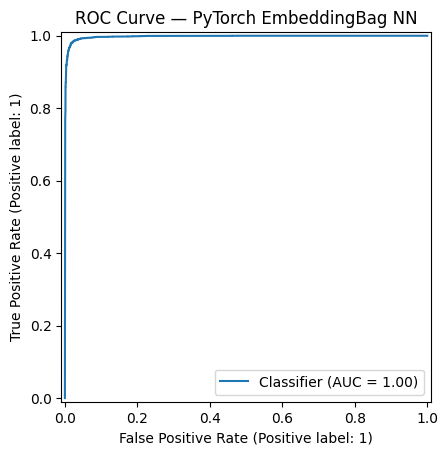

In [28]:
# ROC
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(ytrue, probs, ax=ax)
ax.set_title("ROC Curve — PyTorch EmbeddingBag NN")
plt.show()



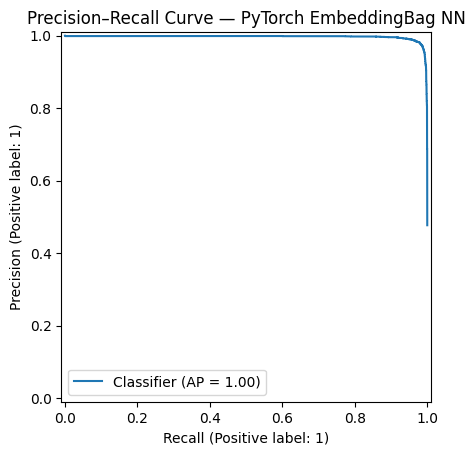

In [29]:
# PR
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(ytrue, probs, ax=ax)
ax.set_title("Precision–Recall Curve — PyTorch EmbeddingBag NN")
plt.show()